In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./walmart-recruiting-store-sales-forecasting/"))


['features.csv.zip', 'sampleSubmission.csv', 'test.csv', 'sampleSubmission.csv.zip', 'train.csv', 'features.csv', 'test.csv.zip', 'train.csv.zip', 'stores.csv']


In [3]:
dataset = pd.read_csv("./walmart-recruiting-store-sales-forecasting/train.csv", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
features = pd.read_csv("./walmart-recruiting-store-sales-forecasting/features.csv", sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("./walmart-recruiting-store-sales-forecasting/stores.csv", names=['Store','Type','Size'],sep=',', header=0)
dataset = dataset.merge(stores, how='left').merge(features, how='left')

# dataset["nextWeekHoliday"] = dataset["isHoliday"].shift(-1).fillna(False)
# dataset["next2WeekHoliday"] = dataset["isHoliday"].shift(-2).fillna(False)
dataset

,Store,Dept,Date,weeklySales,isHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667


## Data Exploration

In [4]:
def scatter(dataset, column):
    plt.figure()
    plt.scatter(dataset[column], dataset['weeklySales'])
    plt.ylabel('weeklySales')
    plt.xlabel(column)

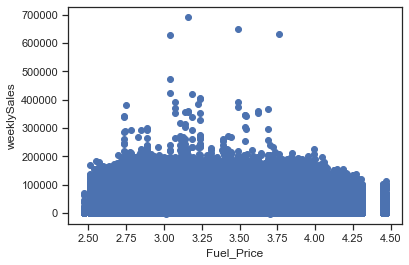

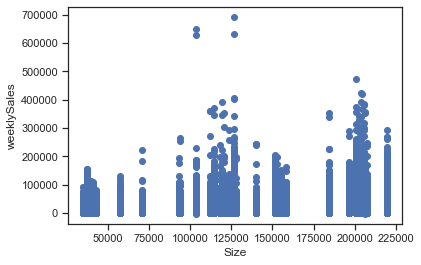

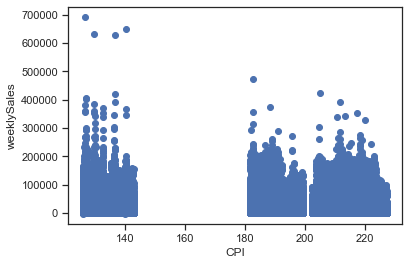

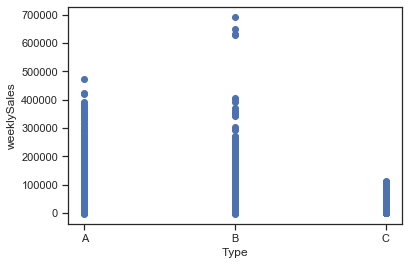

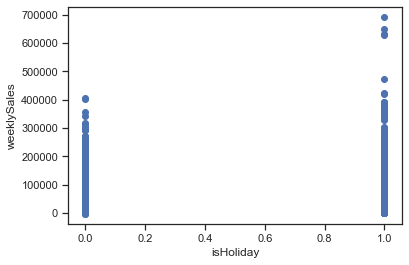

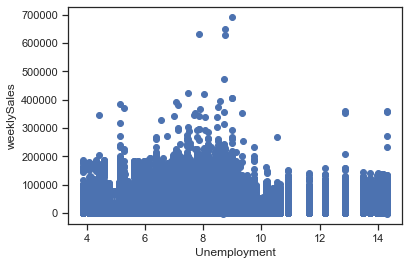

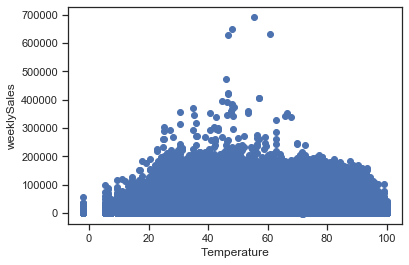

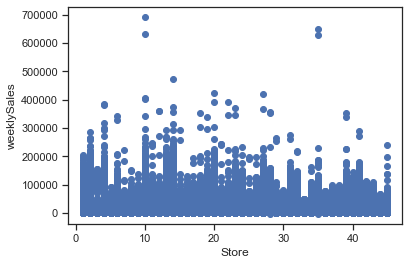

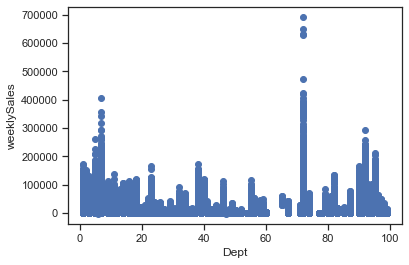

In [5]:
scatter(dataset, 'Fuel_Price')
scatter(dataset, 'Size')
scatter(dataset, 'CPI')
scatter(dataset, 'Type')
scatter(dataset, 'isHoliday')
scatter(dataset, 'Unemployment')
scatter(dataset, 'Temperature')
scatter(dataset, 'Store')
scatter(dataset, 'Dept')

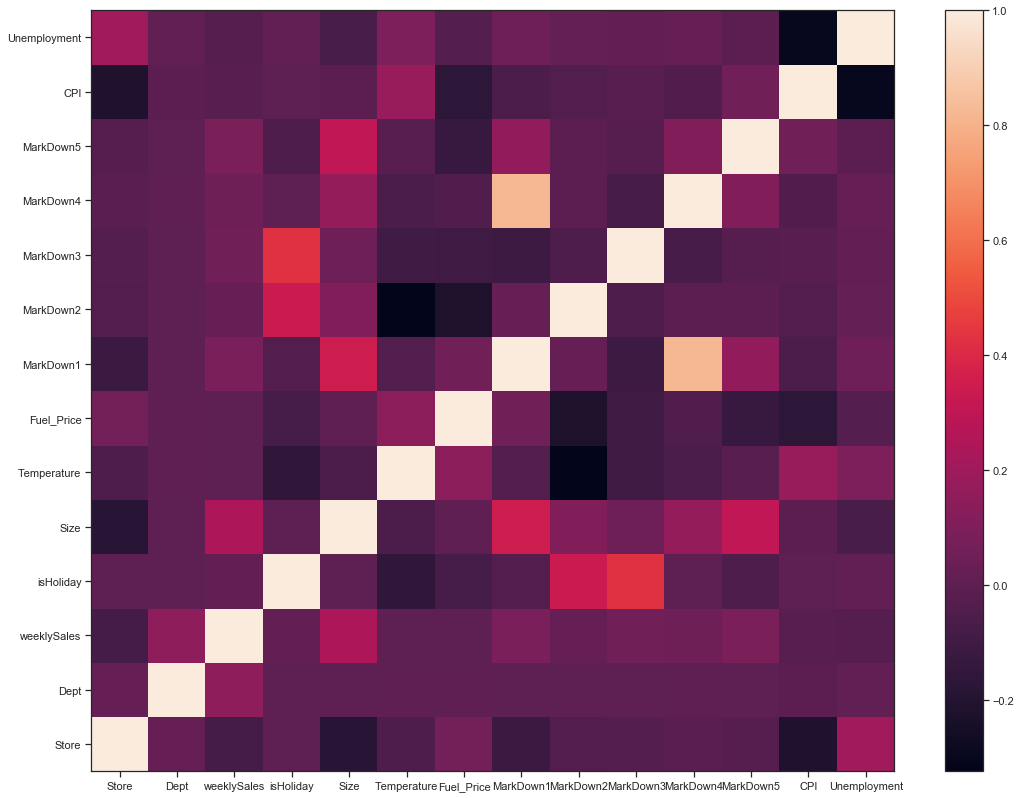

In [6]:
fig = plt.figure(figsize=(18, 14))
corr = dataset.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
fig.colorbar(c)

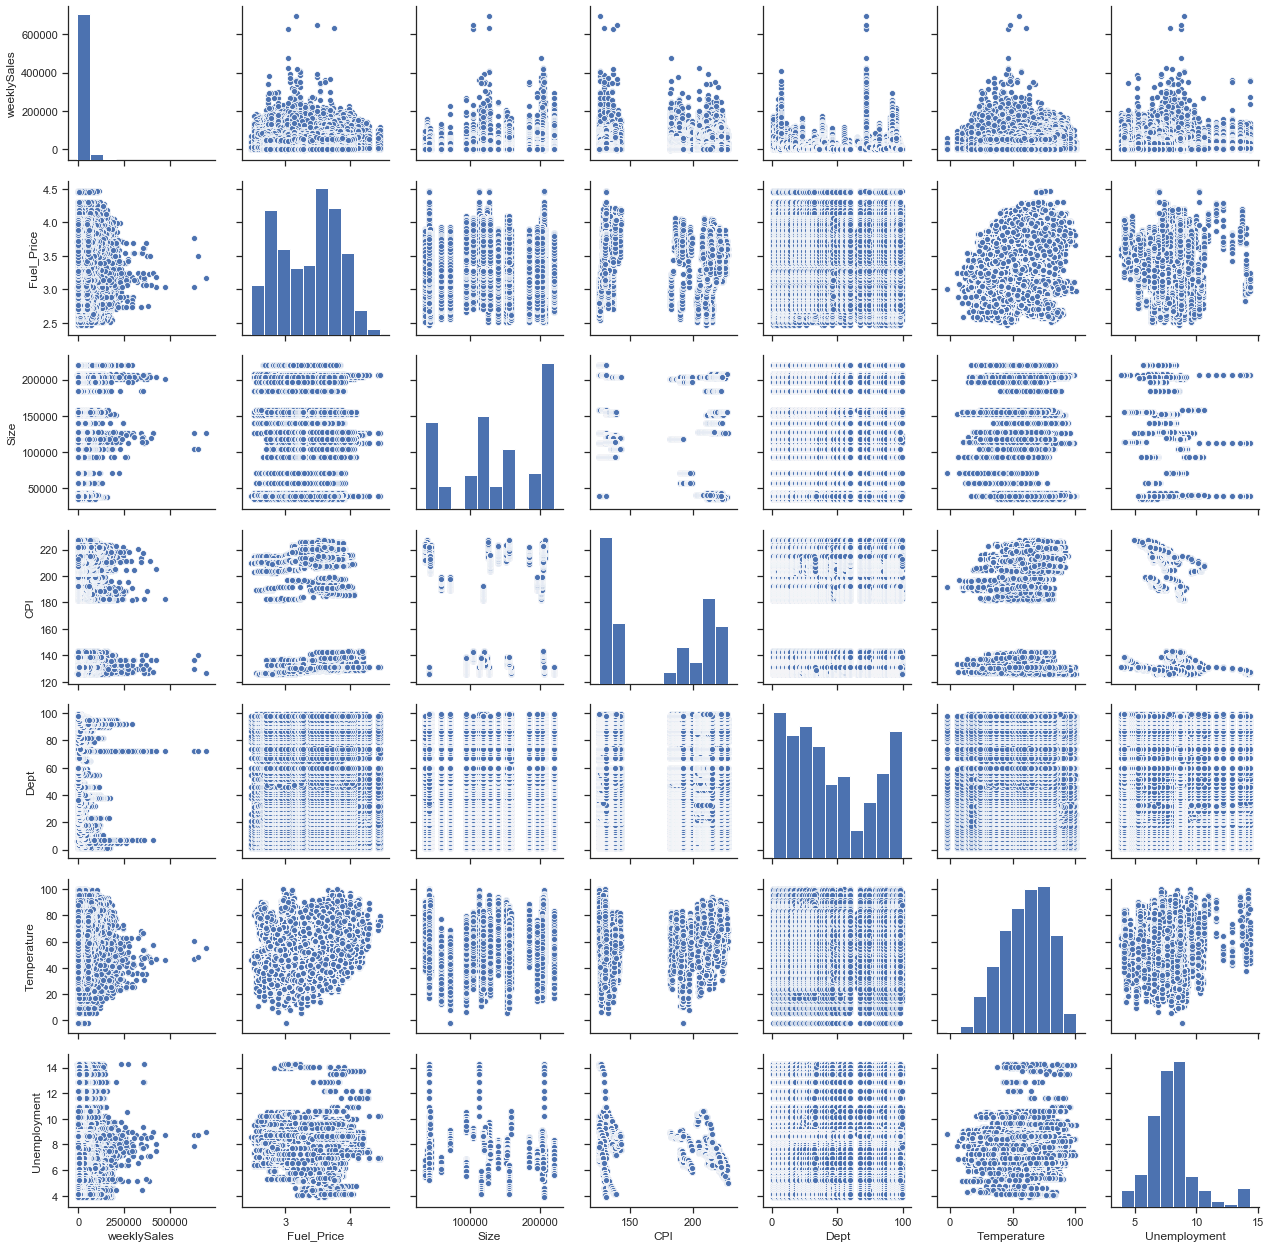

In [7]:
sns.pairplot(dataset, vars=['weeklySales', 'Fuel_Price', 'Size', 'CPI', 'Dept', 'Temperature', 'Unemployment'])

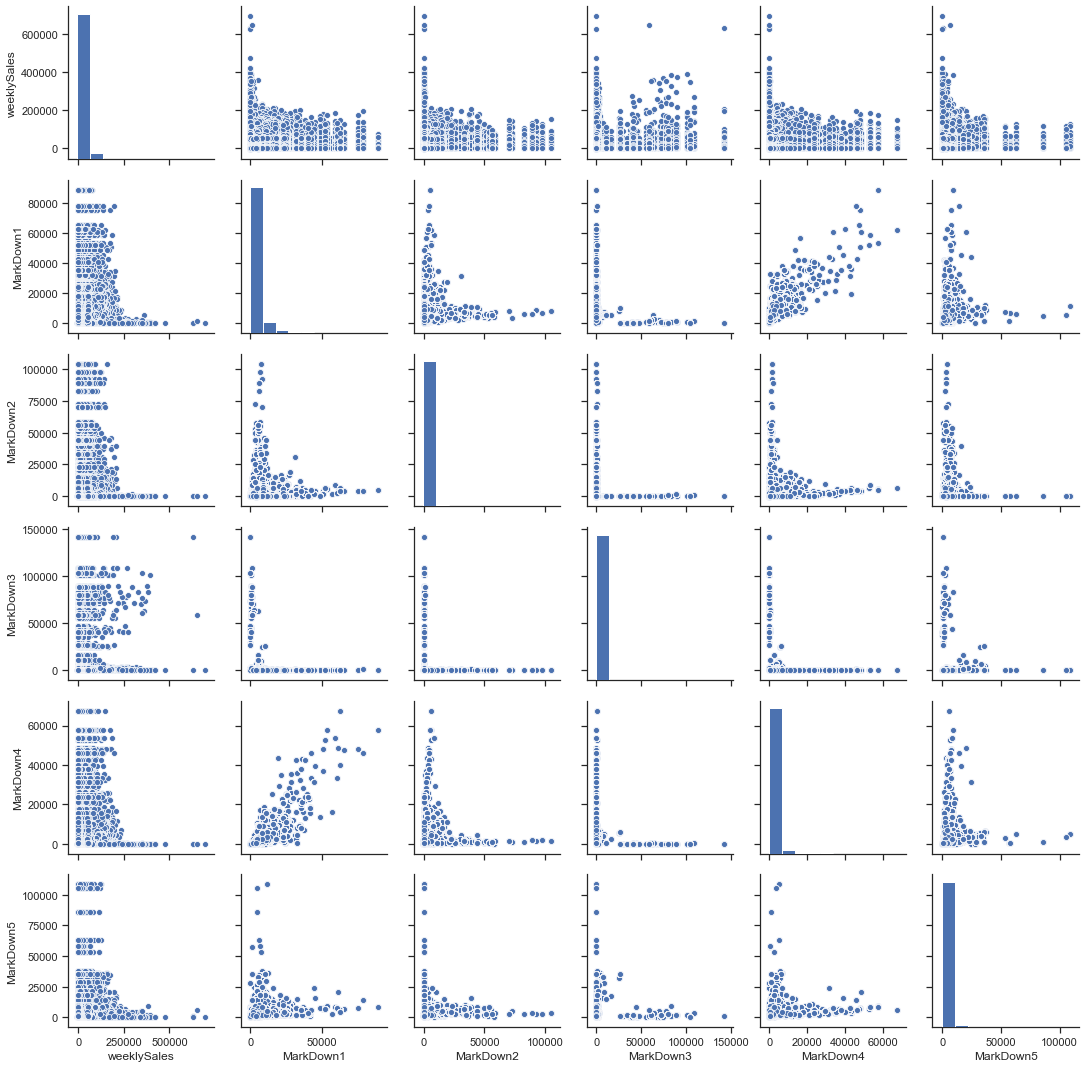

In [8]:
sns.pairplot(dataset.fillna(0), vars=['weeklySales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

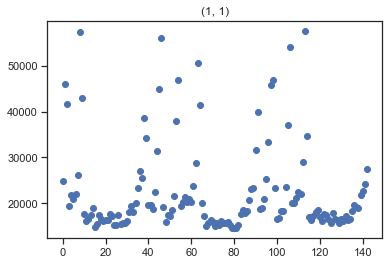

In [9]:
for name, group in dataset.groupby(["Store","Dept"]):
    plt.title(name)
    plt.scatter(range(len(group)), group["weeklySales"])
    plt.show()
    break

## Data Manipulation

In [10]:
dataset = pd.get_dummies(dataset, columns=["Type"])

In [11]:
dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']].fillna(0)

In [12]:
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month

In [13]:
dataset = dataset.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'MarkDown3'])
dataset

,Store,Dept,weeklySales,isHoliday,Size,Temperature,MarkDown1,MarkDown2,MarkDown4,MarkDown5,Type_A,Type_B,Type_C,Month
0,1,1,24924.50,False,151315,42.31,0.00,0.00,0.00,0.00,1,0,0,2
1,1,1,46039.49,True,151315,38.51,0.00,0.00,0.00,0.00,1,0,0,2
2,1,1,41595.55,False,151315,39.93,0.00,0.00,0.00,0.00,1,0,0,2
3,1,1,19403.54,False,151315,46.63,0.00,0.00,0.00,0.00,1,0,0,2
4,1,1,21827.90,False,151315,46.50,0.00,0.00,0.00,0.00,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,508.37,False,118221,64.88,4556.61,20.64,1601.01,3288.25,0,1,0,9
421566,45,98,628.10,False,118221,64.89,5046.74,0.00,2253.43,2340.01,0,1,0,10
421567,45,98,1061.02,False,118221,54.47,1956.28,0.00,599.32,3990.54,0,1,0,10
421568,45,98,760.01,False,118221,56.47,2004.02,0.00,437.73,1537.49,0,1,0,10


## Algorithms

In [14]:
def knn():
    knn = KNeighborsRegressor(n_neighbors=10)
    return knn

def extraTreesRegressor():
    clf = ExtraTreesRegressor(n_estimators=100,max_features='auto', verbose=1, n_jobs=1)
    return clf

def randomForestRegressor():
    clf = RandomForestRegressor(n_estimators=100,max_features='log2', verbose=1)
    return clf

def svm():
    clf = SVR(kernel='rbf', gamma='auto')
    return clf

def nn():
    clf = MLPRegressor(hidden_layer_sizes=(10,),  activation='relu', verbose=3)
    return clf

def predict_(m, test_x):
    return pd.Series(m.predict(test_x))

def model_():
#     return knn()
    return extraTreesRegressor()
#     return svm()
#     return nn()
#     return randomForestRegressor()    

def train_(train_x, train_y):
    m = model_()
    m.fit(train_x, train_y)
    return m

def train_and_predict(train_x, train_y, test_x):
    m = train_(train_x, train_y)
    return predict_(m, test_x), m
#

In [15]:
def calculate_error(test_y, predicted, weights):
    return mean_absolute_error(test_y, predicted, sample_weight=weights)

## K-Fold Cross Validation

In [16]:
kf = KFold(n_splits=5)
splited = []
# dataset2 = dataset.copy()
for name, group in dataset.groupby(["Store", "Dept"]):
    group = group.reset_index(drop=True)
    trains_x = []
    trains_y = []
    tests_x = []
    tests_y = []
    if group.shape[0] <= 5:
        f = np.array(range(5))
        np.random.shuffle(f)
        group['fold'] = f[:group.shape[0]]
        continue
    fold = 0
    for train_index, test_index in kf.split(group):
        group.loc[test_index, 'fold'] = fold
        fold += 1
    splited.append(group)

splited = pd.concat(splited).reset_index(drop=True)


In [17]:
splited

,Store,Dept,weeklySales,isHoliday,Size,Temperature,MarkDown1,MarkDown2,MarkDown4,MarkDown5,Type_A,Type_B,Type_C,Month,fold
0,1,1,24924.50,False,151315,42.31,0.00,0.00,0.00,0.00,1,0,0,2,0.0
1,1,1,46039.49,True,151315,38.51,0.00,0.00,0.00,0.00,1,0,0,2,0.0
2,1,1,41595.55,False,151315,39.93,0.00,0.00,0.00,0.00,1,0,0,2,0.0
3,1,1,19403.54,False,151315,46.63,0.00,0.00,0.00,0.00,1,0,0,2,0.0
4,1,1,21827.90,False,151315,46.50,0.00,0.00,0.00,0.00,1,0,0,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421269,45,98,508.37,False,118221,64.88,4556.61,20.64,1601.01,3288.25,0,1,0,9,4.0
421270,45,98,628.10,False,118221,64.89,5046.74,0.00,2253.43,2340.01,0,1,0,10,4.0
421271,45,98,1061.02,False,118221,54.47,1956.28,0.00,599.32,3990.54,0,1,0,10,4.0
421272,45,98,760.01,False,118221,56.47,2004.02,0.00,437.73,1537.49,0,1,0,10,4.0


In [20]:
best_model = None
error_cv = 0
best_error = np.iinfo(np.int32).max
for fold in range(5):
    dataset_train = splited.loc[splited['fold'] != fold]
    dataset_test = splited.loc[splited['fold'] == fold]
    train_y = dataset_train['weeklySales']
    train_x = dataset_train.drop(columns=['weeklySales','fold'])
    test_y = dataset_test['weeklySales']
    test_x = dataset_test.drop(columns=['weeklySales', 'fold'])
    print(dataset_train.shape, dataset_test.shape)
    predicted, model = train_and_predict(train_x, train_y, test_x)
    weights = test_x['isHoliday'].replace(True, 5).replace(False, 1)
    error = calculate_error(test_y, predicted, weights)
    error_cv += error
    print(fold, error)
    if error < best_error:
        print('Find best model')
        best_error = error
        best_model = model
error_cv /= 5

(335722, 15) (85552, 15)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.8s finished


0 1998.7132629011537
Find best model
(335849, 15) (85425, 15)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.2s finished


1 3151.272135514097
(335970, 15) (85304, 15)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.2s finished


2 1915.190702975241
Find best model
(338733, 15) (82541, 15)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.5s finished


3 2326.48230707267
(338822, 15) (82452, 15)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.5s finished


4 1820.3703617975623
Find best model


In [21]:
error_cv

2242.405754052145

In [22]:
best_error

1820.3703617975623

In [23]:
dataset_test = pd.read_csv("./walmart-recruiting-store-sales-forecasting/test.csv", names=['Store','Dept','Date','isHoliday'],sep=',', header=0)
features = pd.read_csv("./walmart-recruiting-store-sales-forecasting/features.csv",sep=',', header=0,
                       names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                              'MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("./walmart-recruiting-store-sales-forecasting/stores.csv", names=['Store','Type','Size'],sep=',', header=0)
dataset_test = dataset_test.merge(stores, how='left').merge(features, how='left')

In [25]:
dataset_test = pd.get_dummies(dataset_test, columns=["Type"])
dataset_test[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset_test[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset_test = dataset_test.fillna(0)
column_date = dataset_test['Date']
dataset_test['Month'] = pd.to_datetime(dataset_test['Date']).dt.month
dataset_test = dataset_test.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'MarkDown3'])
dataset_test

,Store,Dept,isHoliday,Size,Temperature,MarkDown1,MarkDown2,MarkDown4,MarkDown5,Type_A,Type_B,Type_C,Month
0,1,1,False,151315,55.32,6766.44,5147.70,3639.90,2737.42,1,0,0,11
1,1,1,False,151315,61.24,11421.32,3370.89,4646.79,6154.16,1,0,0,11
2,1,1,False,151315,52.92,9696.28,292.10,1133.15,6612.69,1,0,0,11
3,1,1,True,151315,56.23,883.59,4.17,209.91,303.32,1,0,0,11
4,1,1,False,151315,52.34,2460.03,0.00,150.57,6966.34,1,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,False,118221,76.05,4842.29,975.03,2449.97,3169.69,0,1,0,6
115060,45,98,False,118221,77.50,9090.48,2268.58,5797.47,1514.93,0,1,0,7
115061,45,98,False,118221,79.37,3789.94,1827.31,744.84,2150.36,0,1,0,7
115062,45,98,False,118221,82.84,2961.49,1047.07,363.00,1059.46,0,1,0,7


In [26]:
predicted_test = best_model.predict(dataset_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.6s finished


In [27]:
dataset_test['weeklySales'] = predicted_test
dataset_test['Date'] = column_date
dataset_test['id'] = dataset_test['Store'].astype(str) + '_' +  dataset_test['Dept'].astype(str) + '_' +  dataset_test['Date'].astype(str)
dataset_test = dataset_test[['id', 'weeklySales']]
dataset_test = dataset_test.rename(columns={'id': 'Id', 'weeklySales': 'Weekly_Sales'})

In [28]:
dataset_test.to_csv('output.csv', index=False)